In [1040]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [1041]:
# Ongoing: 
# - show to Paul: 
#     added a constraint_list to the model to enforce that the pattern's 
#     coordinates (the parameters of the calculated bounding pattern) don't overpass the 
#     boundaries (checked several examples in this notebook)

# There is still a bug with the interval_lengths that happens when the model fails to calculate a pattern with postive reals (assumption)

### NEW 15.11.2022

In [1042]:
from enum import Enum

class PatternSpaceType(Enum):
    AXIS_ALIGNED_HYPER_RECTANGLES = 1
    HALF_SPACES = 2

class PatternSpace:
    def __init__(self, type: PatternSpaceType, cutoff: float = 0):
        self.type = type
        self.cutoff = cutoff


import pyomo.environ as pyo
import numpy as np
#from rare_pattern_detect.patterns import PatternSpace


def contains(point: np.ndarray, largest_bounding_area) -> bool:
    return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

def minlp_has_rare_pattern(
    x, training_data, pattern_space: PatternSpace, mu, debugging_minlp_model
):
    min_area = pattern_space.cutoff  # @TODO: Replace with dynamic area calculation
    m = MINLPModel(training_data, min_area)
    if contains(x, m.largest_bounding_area):
        s = m.classify(x, debugging_minlp_model)  # TODO: Parse solution output
        if s == None: 
            print("Error when classifying a point: ", x, m.largest_bounding_area)
            return None, None
        else:
            return m, s <= mu
    else:
        print("point to be classified outside of the limits")
    return None, None


class MINLPModel:
    def __init__(self, training_set: np.array, min_area: float):
        self.training_set = training_set  # a N x d matrix
        self.min_area = min_area  # the smallest allowed area
        self.N, self.d = self.training_set.shape
        self.Nrange, self.drange = (range(x) for x in self.training_set.shape)
        self.largest_bounding_area = np.array(
            [
                [np.min(self.training_set[:, 0]), np.min(self.training_set[:, 1])],
                [np.max(self.training_set[:, 0]), np.max(self.training_set[:, 1])],
            ]
        )
        self.model = self.create_model()

    def create_model(self):
        def _pattern_area():
            return pyo.prod(model.interval_lengths[i] for i in self.drange)

        # define model
        model = pyo.ConcreteModel()

        ## variables

        # x is a 2d vector
        
        model.d_dimension = pyo.Set(initialize=self.drange)
        def adjust_largest_pattern_bounds(model, i, j):
            # print("adjust_largest_pattern_bounds: ", i) 
            min_b = np.min(self.training_set[:,i])
            max_b = np.max(self.training_set[:,i])
            return min_b, max_b

        model.pattern = pyo.Var(self.drange , self.drange , bounds=adjust_largest_pattern_bounds)


        # y is a boolean vector of size N
        model.included = pyo.Var(self.Nrange, within=pyo.Binary, initialize=0)

        # auxiliary variables
        # print("self.drange", self.drange)
        model.interval_lengths = pyo.Var(self.drange, within=pyo.NonNegativeReals)
        model.point_left_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )
        model.point_right_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )

        ## objective (minimised by default)
        model.obj = pyo.Objective(
            expr=sum(model.included[i] for i in self.Nrange) / _pattern_area(),
            sense=pyo.minimize,
        )

        ## constraints

        # pattern area needs to exceed min_area
        model.area_constraint = pyo.Constraint(expr=_pattern_area() >= self.min_area)

        # training points included in model.included lie within the pattern (NB: In principle we would need to ensure that points not included are also
        # not included in model.included. However, since including points outside the pattern increases the objective, this is covered.)

        model.include_constraint = pyo.ConstraintList()
        model.enforce_point_left_of_pattern = pyo.ConstraintList()
        model.enforce_point_right_of_pattern = pyo.ConstraintList()
        M = 100000
        for j in self.Nrange:
            for i in self.drange:
                # enforcing auxiliary variables are correct: point_left_of_pattern[j,i] is True iff the jth training point lies strictly outside the pattern in ith dimension, etc.
                model.enforce_point_left_of_pattern.add(
                    (model.point_left_of_pattern[j, i] * M + self.training_set[j, i])
                    >= model.pattern[0, i]
                )
                model.enforce_point_left_of_pattern.add(
                    self.training_set[j, i] + 1e-3
                    <= (
                        model.pattern[0, i]
                        + (1 - model.point_left_of_pattern[j, i]) * M
                    )
                )
                model.enforce_point_right_of_pattern.add(
                    self.training_set[j, i]
                    <= (model.pattern[1, i] + model.point_right_of_pattern[j, i] * M)
                )
                model.enforce_point_right_of_pattern.add(
                    (
                        (1 - model.point_right_of_pattern[j, i]) * M
                        + self.training_set[j, i]
                    )
                    >= (model.pattern[1, i] + 1e-3)
                )

            model.include_constraint.add(
                # key bit: this constraint enforces that the model.included for jth point can be set to 0 only if the point is not contained in the pattern (as witnessed by the fact
                # that the corresponding auxiliary variables are all 0)
                model.included[j]
                + sum(
                    model.point_right_of_pattern[j, i]
                    + model.point_left_of_pattern[j, i]
                    for i in self.drange
                )
                >= 1
            )

        # connect auxiliary variables: interval lengths are differences of pattern points
        model.interval_constraint = pyo.ConstraintList()
        model.pattern_constraint = pyo.ConstraintList()
        # print("self.drange: ", self.drange)
        for i in self.drange:
            # print("model.pattern: ", i, model.pattern[1, i], model.pattern[0, i])
            model.pattern_constraint.add(
                model.pattern[0,i] >= np.min(self.training_set[:,i])
            )
            model.pattern_constraint.add(
                model.pattern[1,i] <= np.max(self.training_set[:,i])
            )
            model.interval_constraint.add(
                model.interval_lengths[i] == model.pattern[1, i] - model.pattern[0, i]
            )
            # model.pattern_constraint.add(
            #     model.pattern[1,i] <= np.max(self.training_set[:,i])
            # )
            # model.pattern_constraint.add(
            #     model.pattern[1,i] <= np.max(self.training_set[:,i])
            # )
            # model.pattern_constraint.add(
            #     model.pattern[0,i] >= np.min(self.training_set[:,i])
            # )
            # model.pattern_constraint.add(
            #     model.pattern[1,i] <= np.max(self.training_set[:,i])
            # )
            # model.pattern_constraint.add(
            #     model.pattern[0,i] >= np.min(self.training_set[:,i])
            # )
            # model.pattern_constraint.add(
            #     model.interval_lengths[i] - model.pattern[1,i] >= np.min(self.training_set[:,i])
            # )
        
        return model

    def extract_points_included_in_pattern(self):
        included_points = []
        for i in self.model.included:
            if np.round(self.model.included[i].value, 1) == 1.0:
                included_points.append(self.training_set[i])
        return np.array(included_points)

    def extract_pattern(self):
        intervals = np.zeros((2, 2), dtype=float)
        for _, j in enumerate(self.model.pattern):
            intervals[j] = self.model.pattern[j].value
        return intervals.T

    def classify(self, point_to_be_classified: np.array, tee):
        # point to be classified is a 1 x d array
        self.add_point_to_model(point_to_be_classified)
        _ = pyo.SolverFactory("mindtpy").solve(
            self.model,
            strategy="OA",
            mip_solver="glpk",
            nlp_solver="ipopt",
            tee=tee,
        )
        try:
            res = pyo.value(self.model.obj)
        except: 
            print("Something went wrong with the solver in -classify- when classifying: ", point_to_be_classified)
            res = None 
        finally:
            return res
         

    def add_point_to_model(self, point):
        # point to be classified lies in pattern
        point = point.squeeze()
        assert point.shape == (2,)
        self.model.point_constraint = pyo.ConstraintList()
        for i in self.drange:
            # x[i] <= point[i] <= x[i + d], for all i
            self.model.point_constraint.add(self.model.pattern[0, i] <= point[i])
            self.model.point_constraint.add(point[i] <= self.model.pattern[1, i])


#from rare_pattern_detect.patterns import PatternSpaceType
#from rare_pattern_detect.minlp_based import minlp_has_rare_pattern

import unittest
class RarePatternDetect:
    def __init__(self, delta, tau, epsilon, pattern_space):
        self.training_data = None
        self.delta = delta
        self.tau = tau
        self.epsilon = epsilon
        self.pattern_space = pattern_space

        if pattern_space.type == PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES:
            self.has_rare_pattern = minlp_has_rare_pattern
        else:
            self.has_rare_pattern = None

    def load_training_data(self, training_data):
        self.training_data = training_data

    def is_anomalous(self, x):
        return self.has_rare_pattern(
            x, self.training_data, self.pattern_space, self.tau + self.epsilon / 2
        )

In [1043]:
# training_set =  np.array(
#     [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
# )
# point_to_be_classified = np.array([0.25,0.25])
training_set = multivariate_normal.rvs(size=(20,2))
testing_set = multivariate_normal.rvs(size=(40,2))

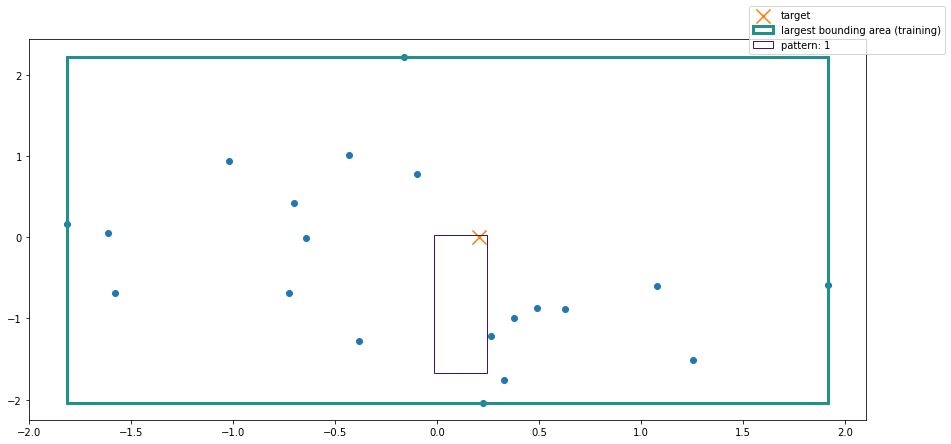

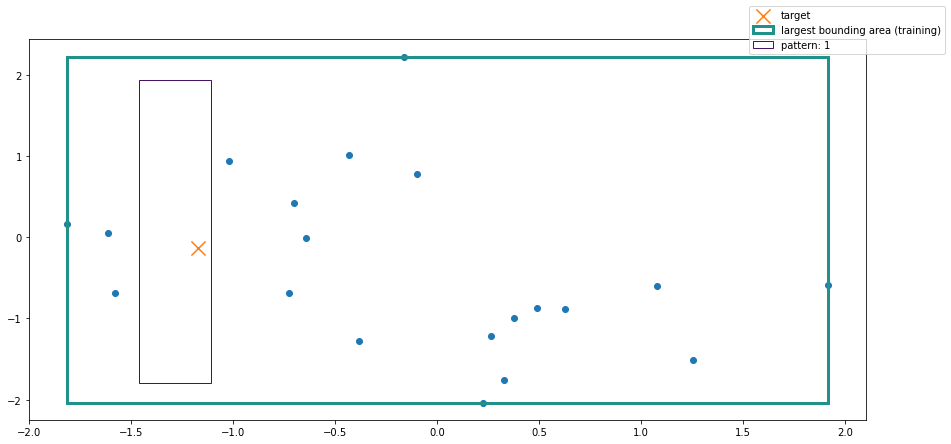

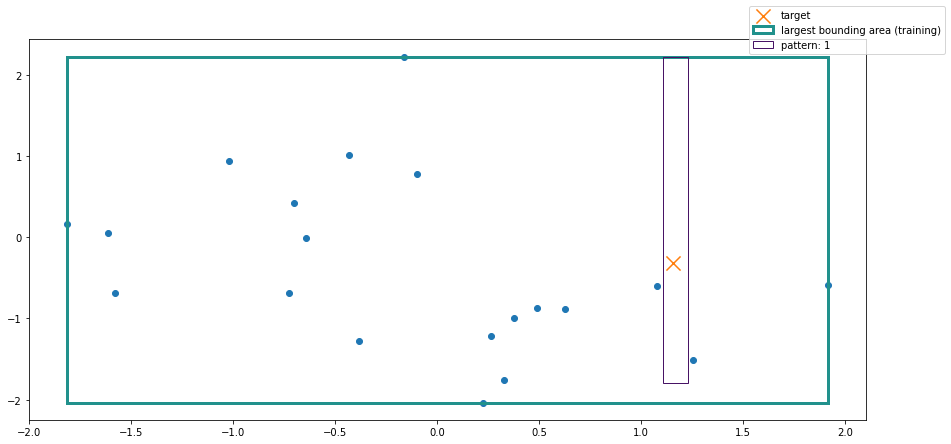

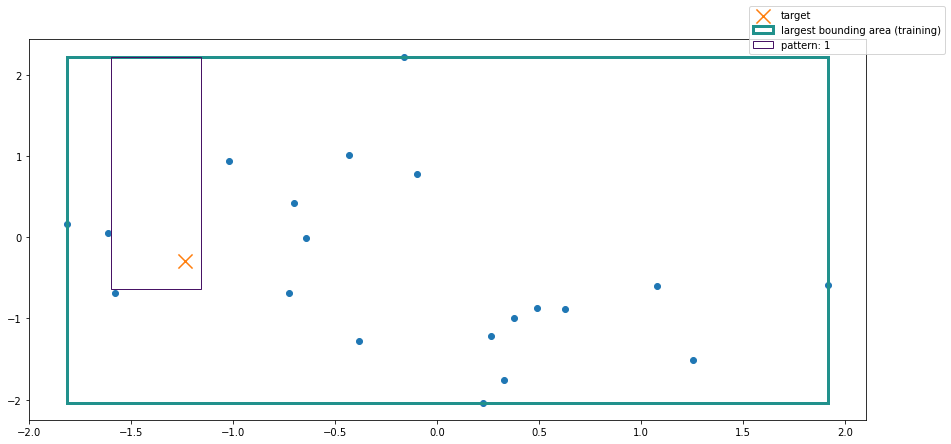

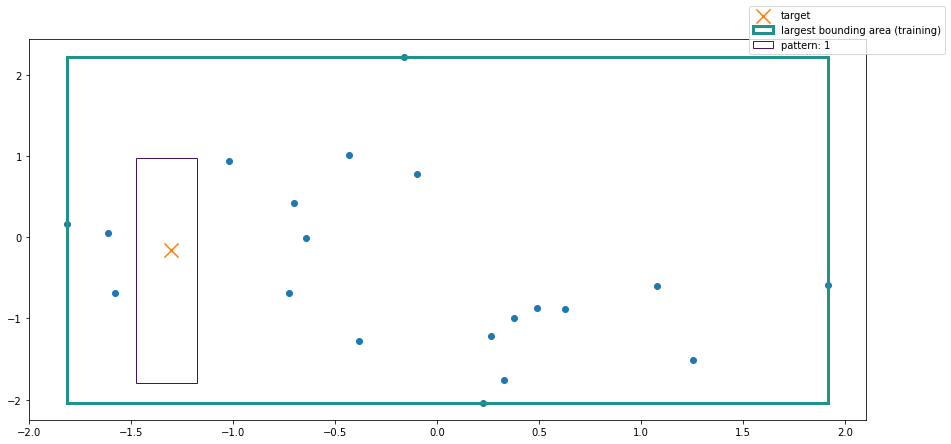

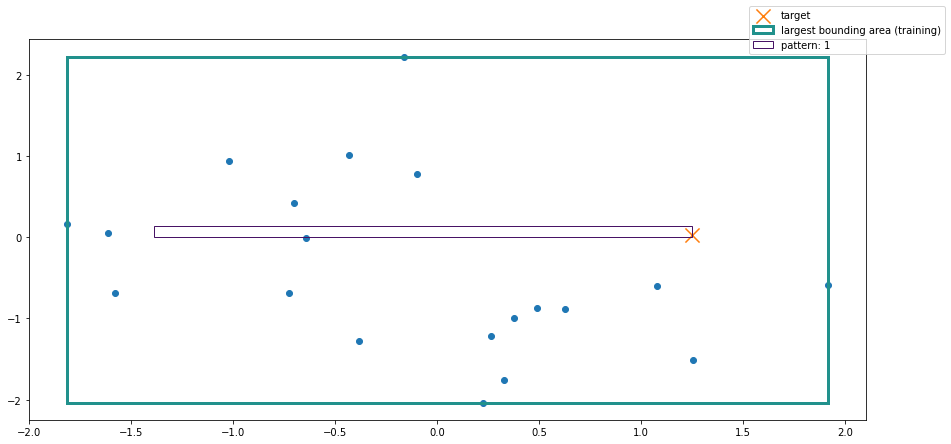

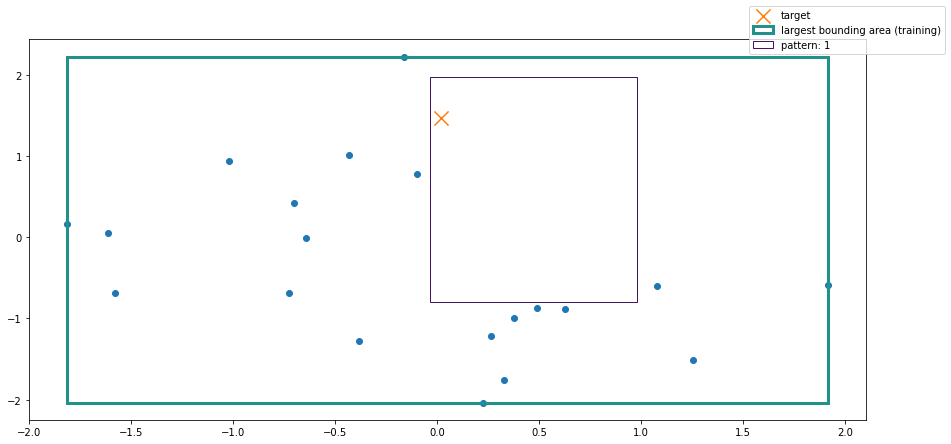

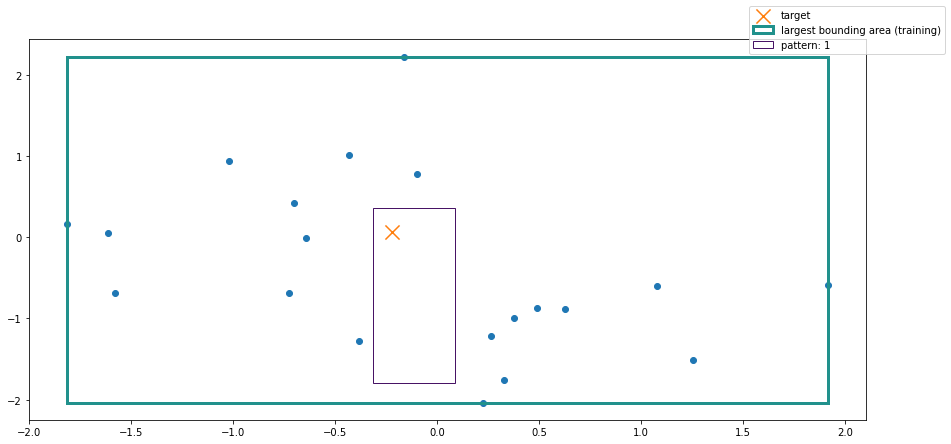

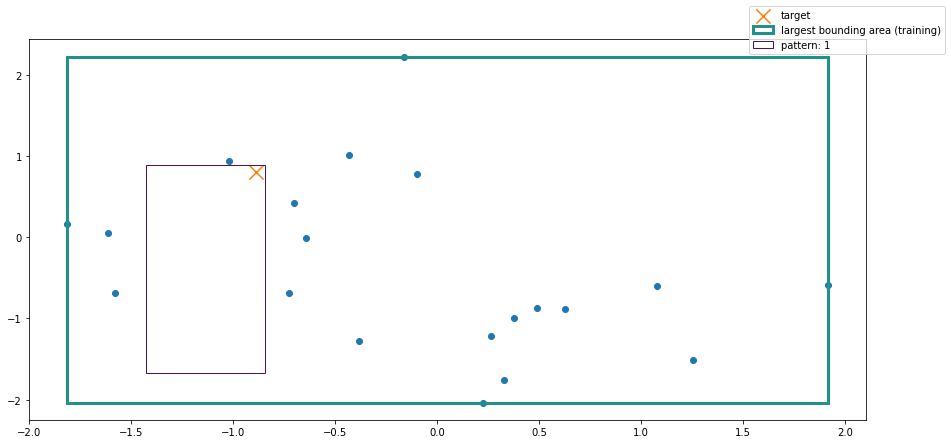

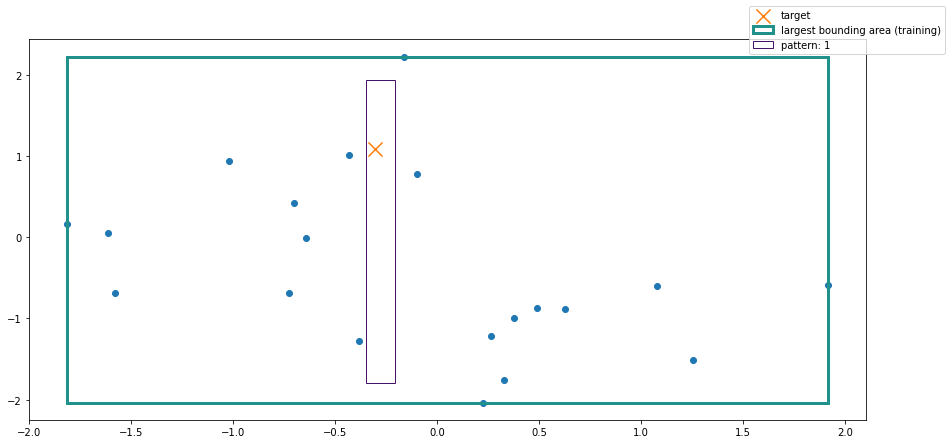

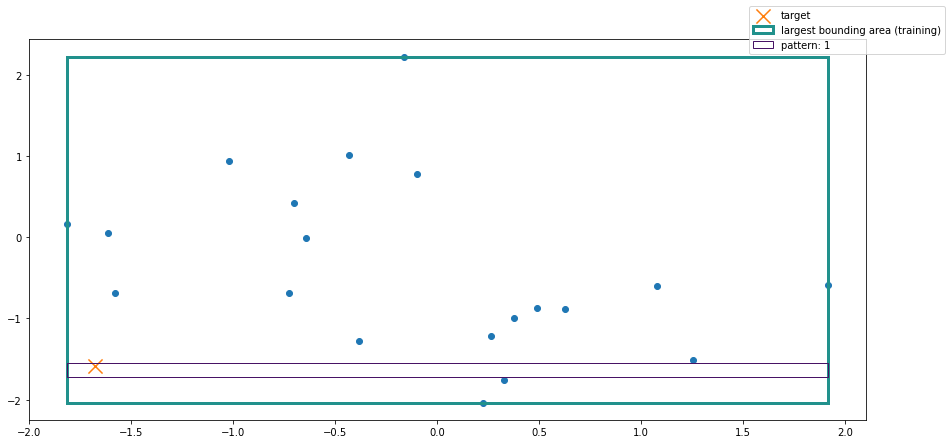

point to be classified outside of the limits


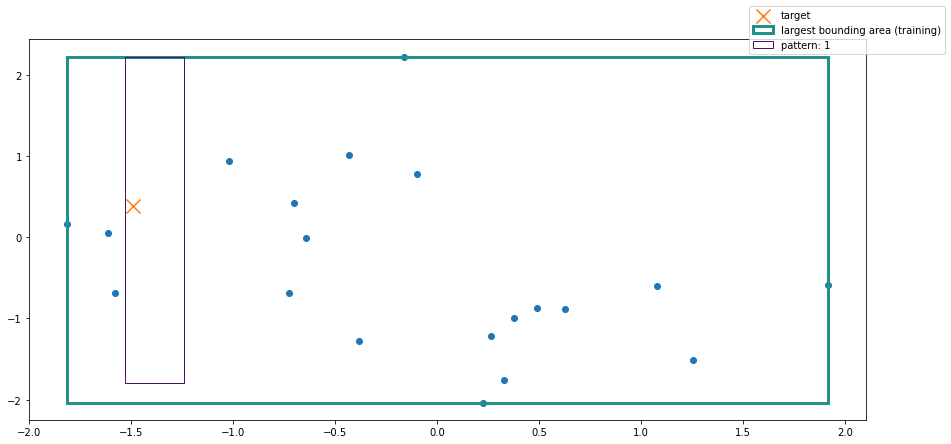

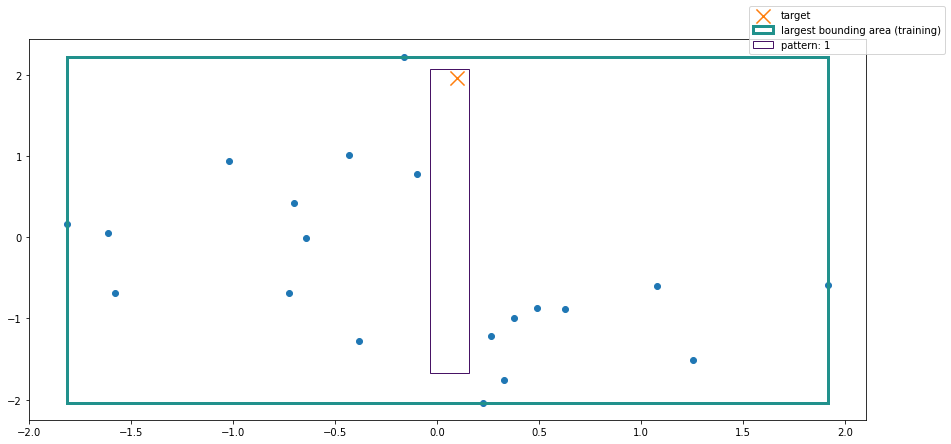

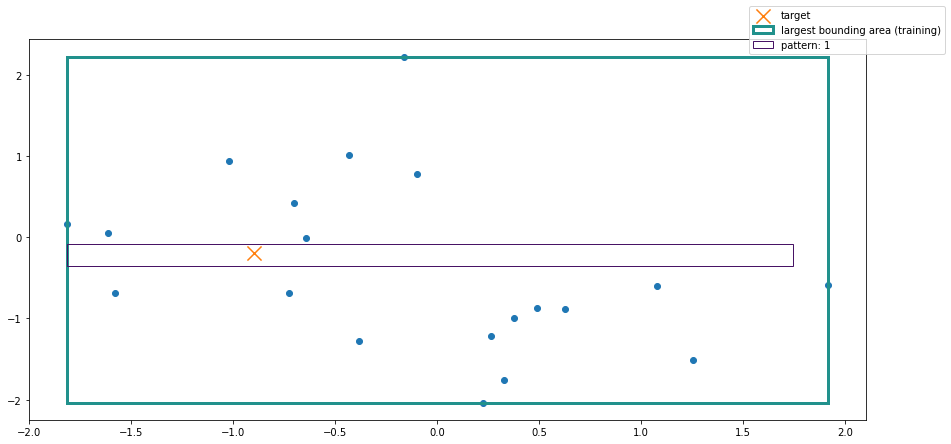

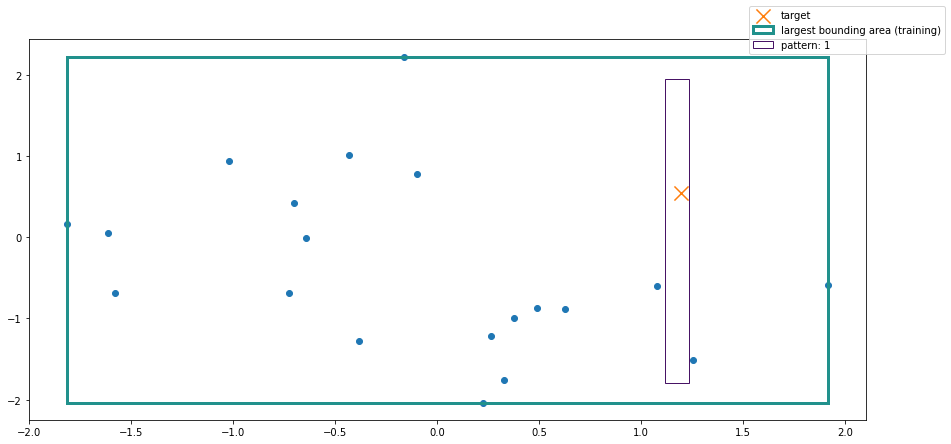

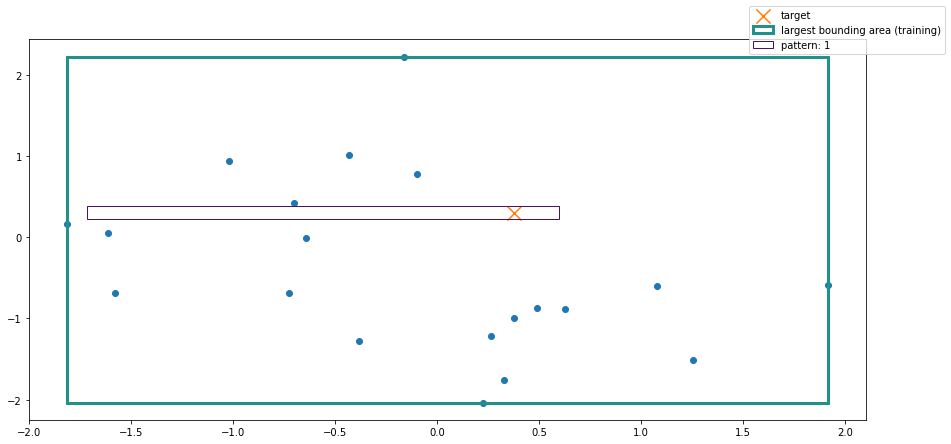

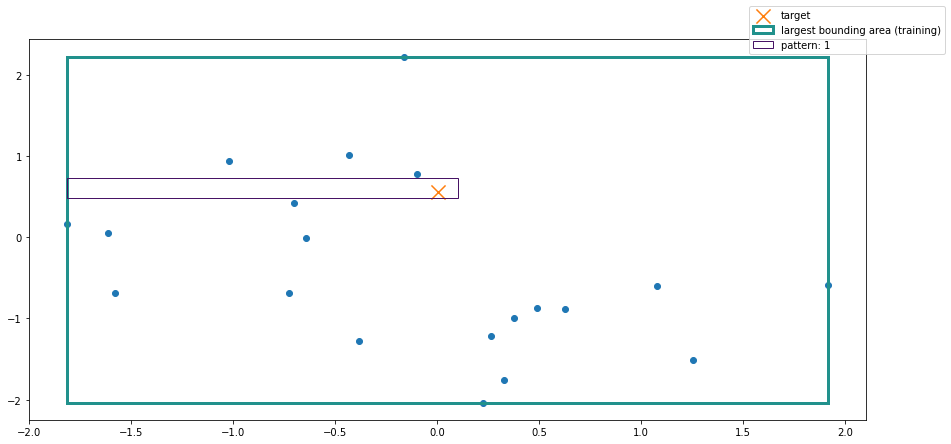

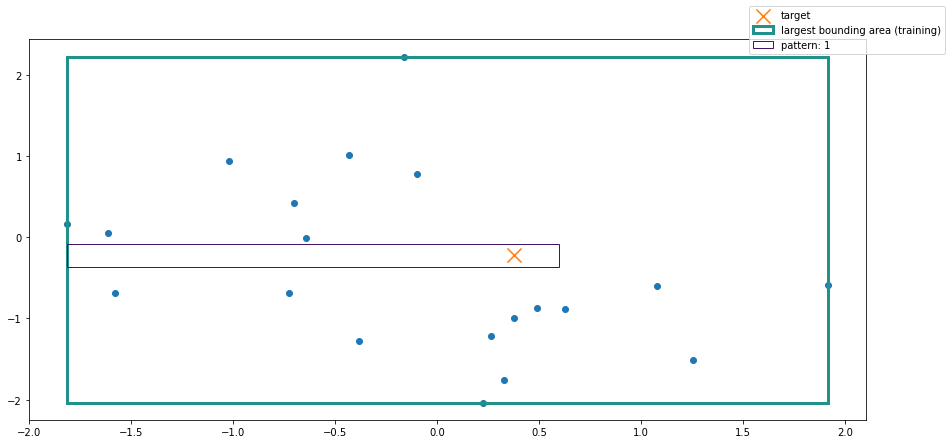

point to be classified outside of the limits


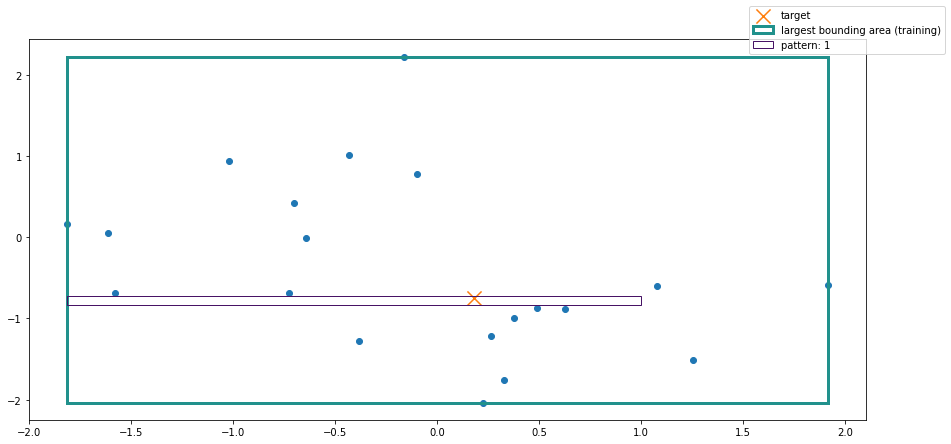

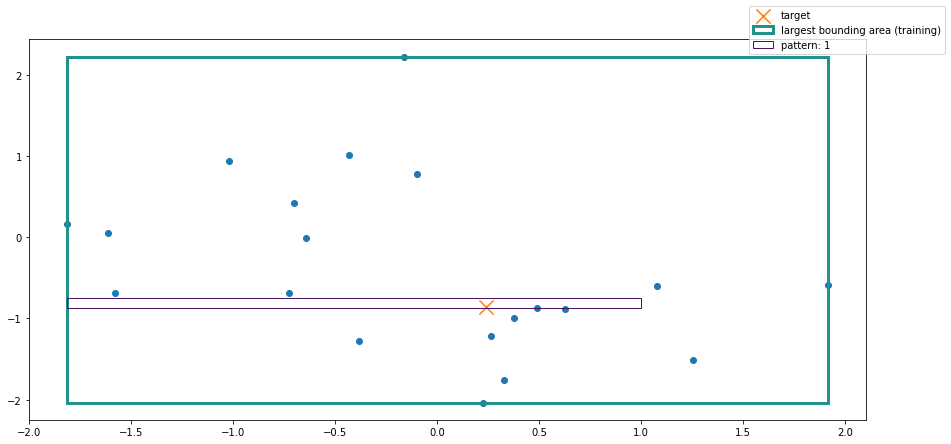

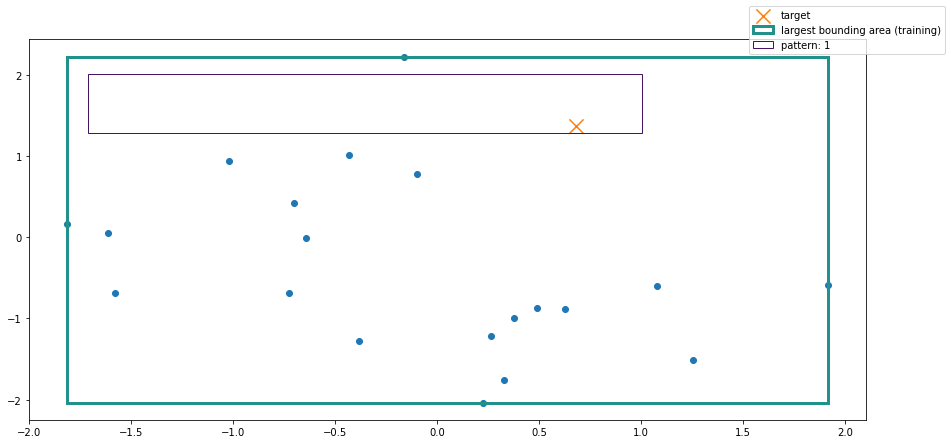

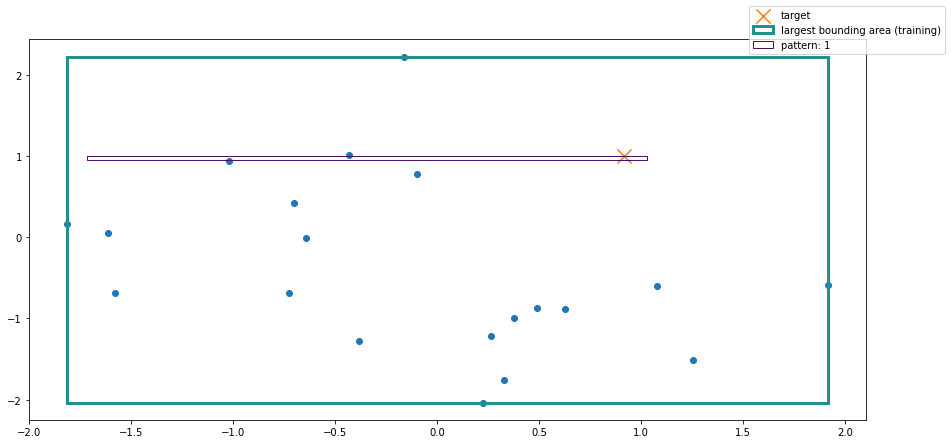

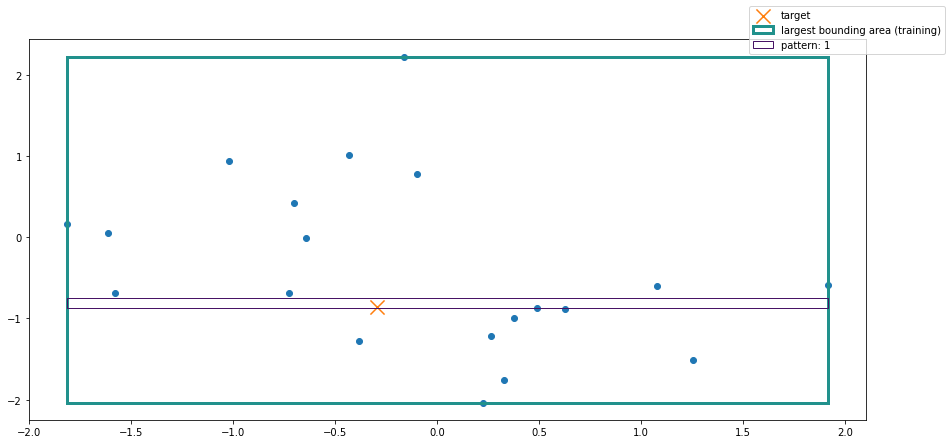

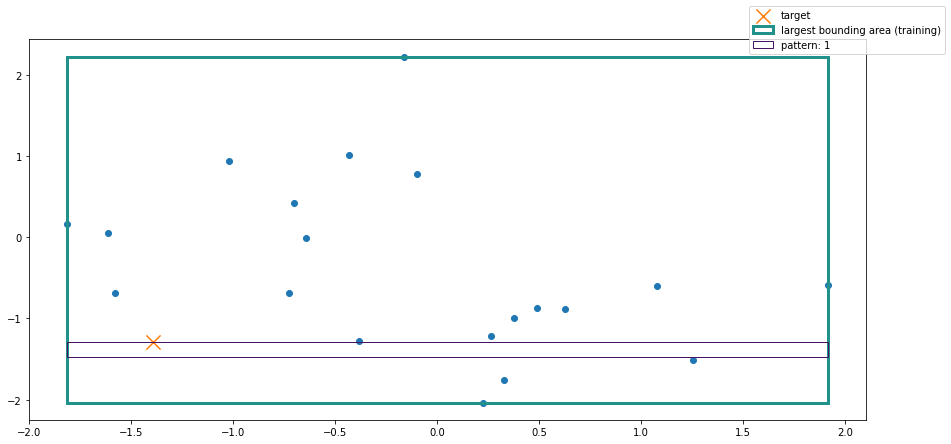

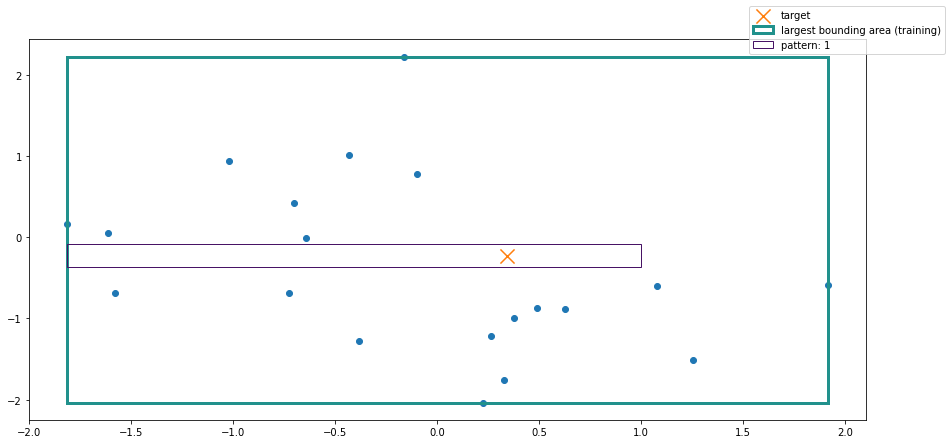

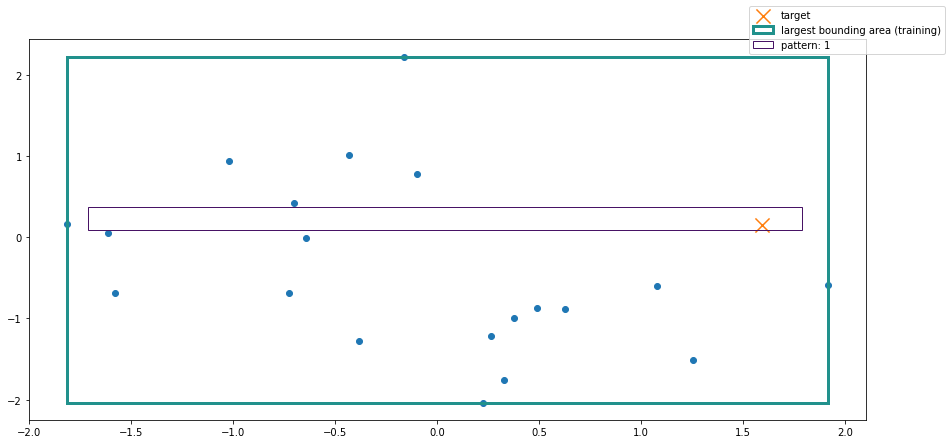

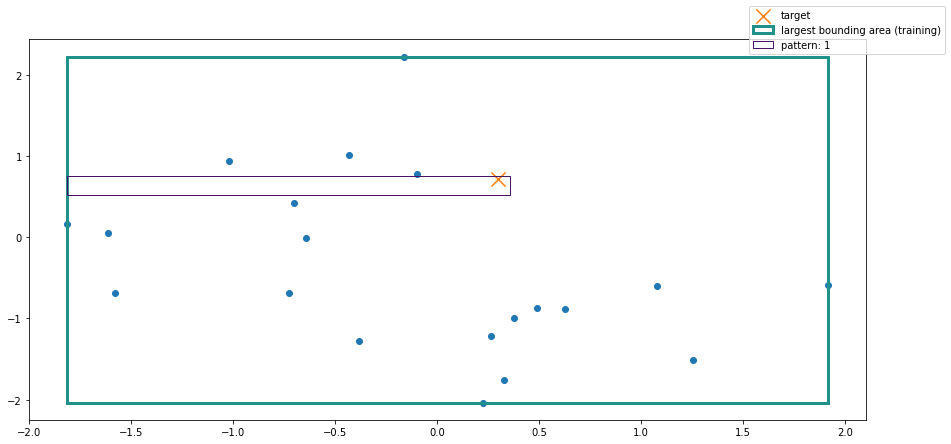

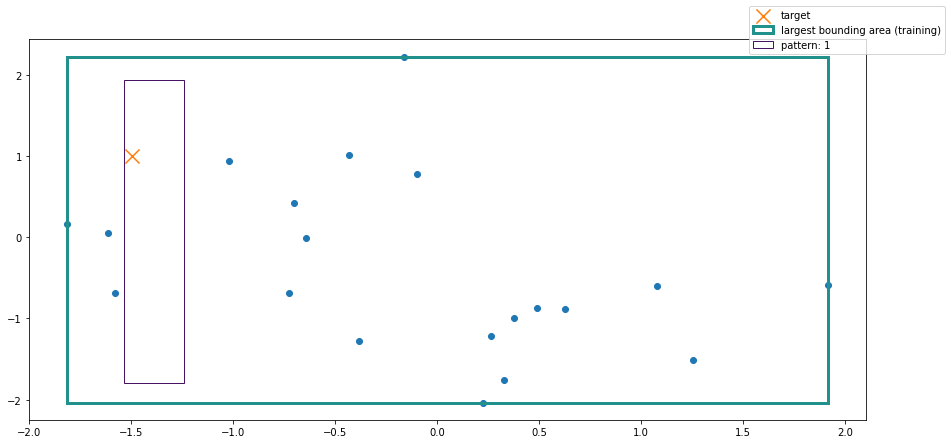

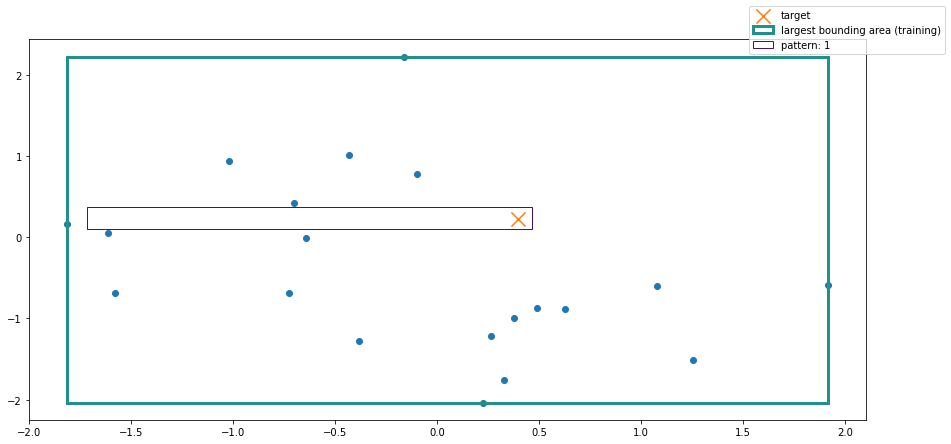

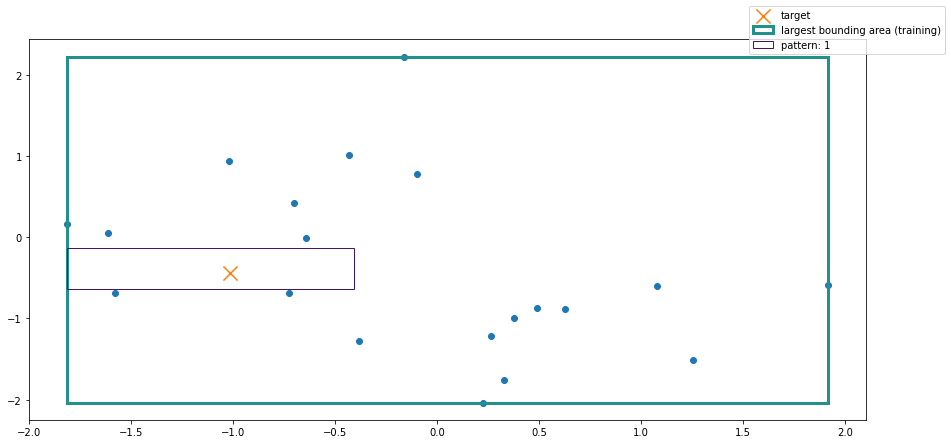

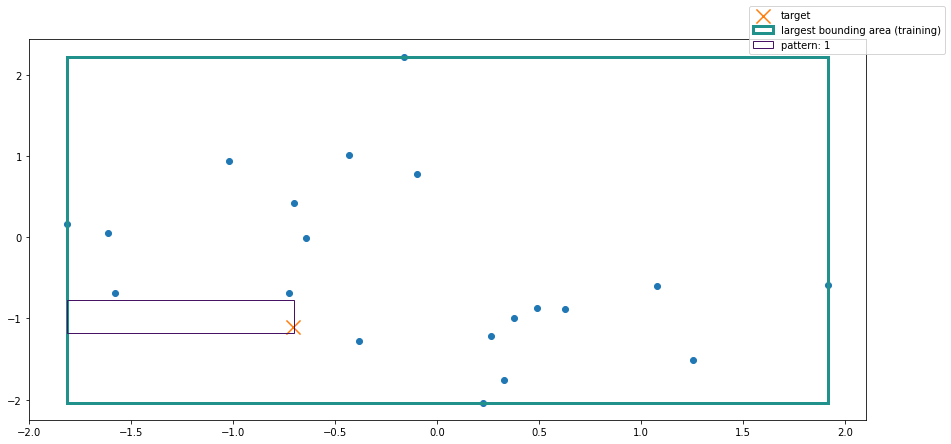

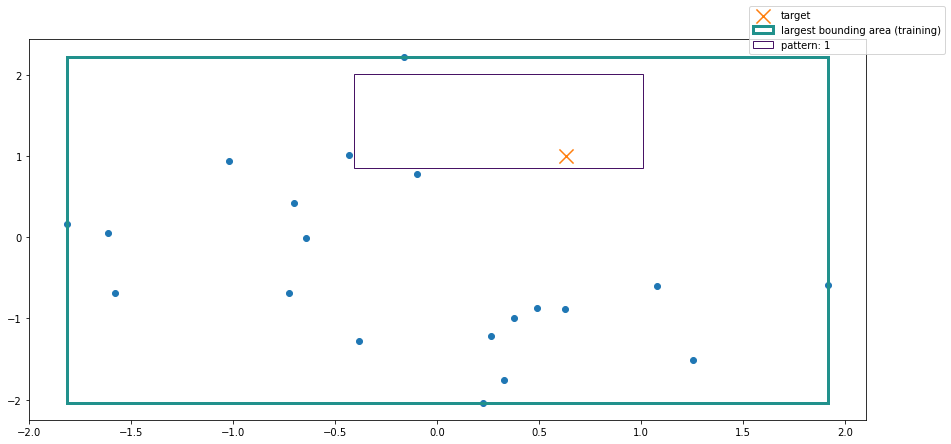

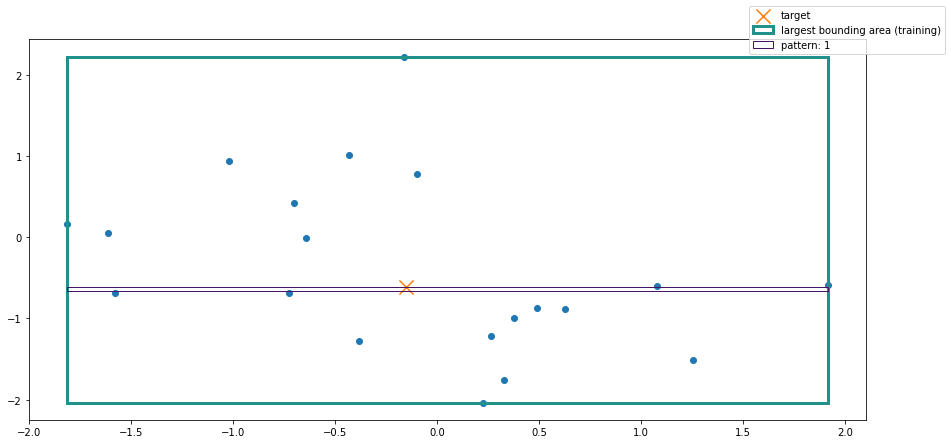

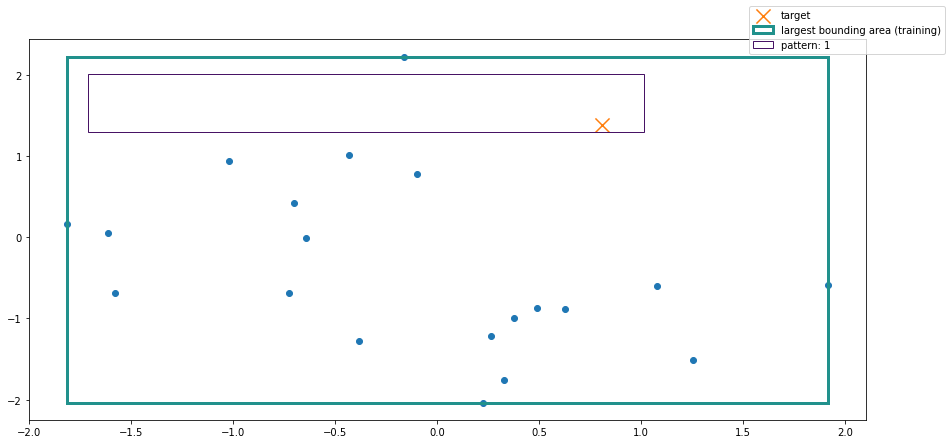

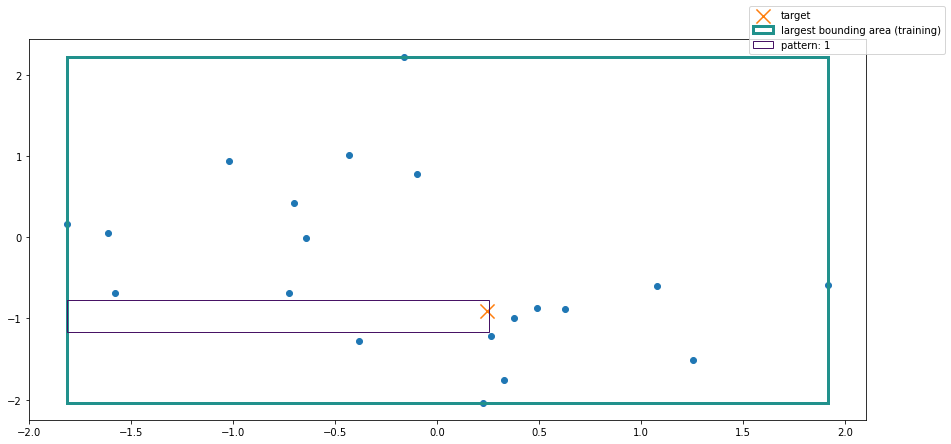

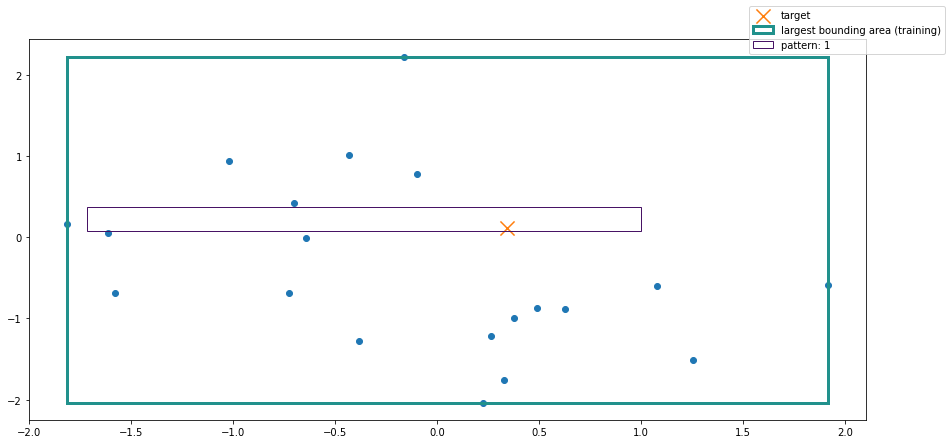

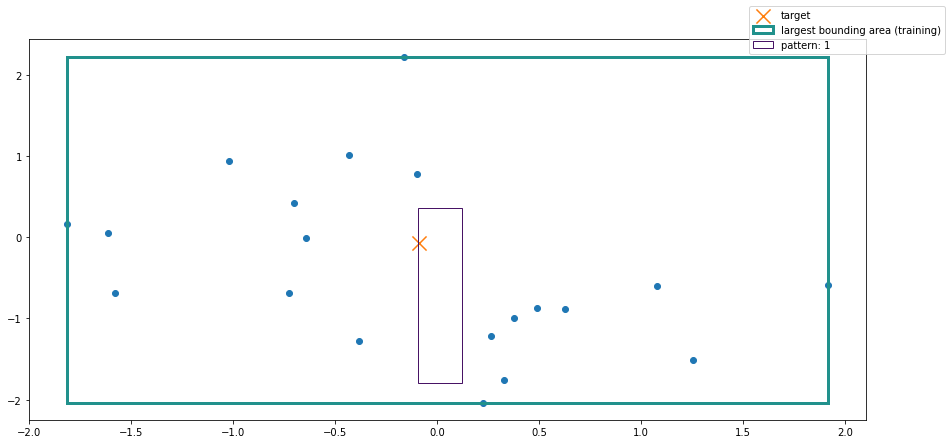

point to be classified outside of the limits
Points that lie outside of the largest bounding area defined by the training set:  3
indices of the points:  [11, 19, 39]


In [1044]:
cmap = plt.get_cmap('viridis')

def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.5),
        label= "largest bounding area (training)",
        linewidth=3.0
        )
    )

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )

plt.rcParams["figure.figsize"] = (15,7)

points_outside_of_largest_bounding_area = 0
indeces = []
for i, p in enumerate(testing_set):

    point_to_be_classified = p
    min_area = 0.1
    mu = 0.1

    pattern_space = PatternSpace(
        PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
        cutoff=min_area
    )

    minlp_model, classification_result = minlp_has_rare_pattern(
        point_to_be_classified,
        training_set,
        pattern_space,
        mu,
        debugging_minlp_model=False,
    )

    if classification_result is not None: 
        result = (
            min_area,
            mu,
            classification_result,
            minlp_model
        )

        calculated_pattern = minlp_model.extract_pattern()
        included_points = minlp_model.extract_points_included_in_pattern()
        largest_bounding_area = minlp_model.largest_bounding_area

        plt.scatter(x=training_set[:,0], y=training_set[:,1])
        plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
        for i, p in enumerate(included_points):
            plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_set == p)[0,0]}")
        ax = plt.gca()
        draw_largest_bounding_area(largest_bounding_area.T, ax)
        draw2dpattern(calculated_pattern, ax, 1, len(training_set))
        ax.legend(bbox_to_anchor=(1.1, 1.1))
        plt.show()
    else:
        points_outside_of_largest_bounding_area += 1 
        indeces.append(i)

print("Points that lie outside of the largest bounding area defined by the training set: ",points_outside_of_largest_bounding_area) 
print("indices of the points: ", indeces)